In [113]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

tf.keras.backend.clear_session()
seed = 9
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)


# Data loading and preprocessing

In [115]:
#load the fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#normalise the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Building a model through hyperparameter tuning

In [116]:
def model_builder(hp):
    # Create a Sequential model
    model = Sequential()
    
    #flatten the input images
    model.add(Flatten(input_shape=(28,28)))
    
    #define hyperparameter values to search for the optimum  
    activation_param = hp.Choice('activation', values=['relu', 'tanh'])
    layer1_param = hp.Int('layer1', min_value=100, max_value=1000, step=50)
    layer2_param = hp.Int('layer2', min_value=100, max_value=1000, step=50)
    
    lr_param = hp.Choice('learning_rate', values= [0.001, 0.0005, 0.00025, 0.0001])
    optimizer_param = hp.Choice('optimizer', values=['adam', 'nadam', 'sgd', 'rmsprop'])
    
    
    #add dense layers to the model with values from the hyperparameter space
    model.add(Dense(units=layer1_param, activation=activation_param))
    model.add(Dense(units=layer2_param, activation=activation_param))
    model.add(Dense(10, activation='softmax'))
    
    # Define optimizers based on the hyperparameter choice
    if optimizer_param == 'adam':
        optimizer = Adam(learning_rate=lr_param)
    elif optimizer_param == 'nadam':
        optimizer = Nadam(learning_rate=lr_param)
    elif optimizer_param == 'sgd':
        optimizer = SGD(learning_rate=lr_param)
    else:
        optimizer = RMSprop(learning_rate=lr_param)
    
    # Compile the model with the selected optimizer
    model.compile(optimizer=optimizer, 
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

In [117]:
# Create a Hyperband tuner for hyperparameter optimization
tuner = keras_tuner.Hyperband(
    model_builder,             # call our function to build the model
    objective='val_accuracy',  # define metric to optimize
    max_epochs=15,             # Max number of training epochs per model
    factor=3,                  
    directory='dir',           
    project_name='hband_tuner'           
)


In [118]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # define early stop

In [119]:
# use Hyperband tuner to search for the best hyperparameters
tuner.search(
    X_train,                    # Training data
    y_train,                    # Training labels
    epochs=10,                  # number of training epochs per model
    validation_split=0.2,       # Fraction of training data used for validation
    callbacks=[early_stop]      # define callback as our early stop method
)


Trial 28 Complete [00h 02m 04s]
val_accuracy: 0.887416660785675

Best val_accuracy So Far: 0.8990833163261414
Total elapsed time: 00h 21m 56s


In [121]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0] #get the best performing hyperparameters

# List of hyperparameters to iterate through
hyperparameter_names = ['activation', 'layer1', 'layer2', 'learning_rate', 'optimizer']

# Iterate through the list and display the best values
print("Best Hyperparameters:")
for param_name in hyperparameter_names:
    param_value = best_params.get(param_name)
    print(f"{param_name.capitalize()}: {param_value}")

Best Hyperparameters:
Activation: relu
Layer1: 200
Layer2: 350
Learning_rate: 0.0005
Optimizer: adam


In [122]:
#build model with best params
best_model = tuner.hypermodel.build(best_params) 

early_stop_best_model = EarlyStopping(monitor='val_loss', patience=7)  # define early stop for training the best model


#train best model on the train data
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.15, callbacks=[early_stop_best_model]) 

Epoch 1/50
1594/1594 [==============================] - 6s 3ms/step - loss: 0.4959 - accuracy: 0.8230 - val_loss: 0.3906 - val_accuracy: 0.8581
Epoch 2/50
1594/1594 [==============================] - 5s 3ms/step - loss: 0.3616 - accuracy: 0.8668 - val_loss: 0.3795 - val_accuracy: 0.8606
Epoch 3/50
1594/1594 [==============================] - 5s 3ms/step - loss: 0.3223 - accuracy: 0.8809 - val_loss: 0.3474 - val_accuracy: 0.8749
Epoch 4/50
1594/1594 [==============================] - 5s 3ms/step - loss: 0.2977 - accuracy: 0.8892 - val_loss: 0.3493 - val_accuracy: 0.8720
Epoch 5/50
1594/1594 [==============================] - 5s 3ms/step - loss: 0.2797 - accuracy: 0.8950 - val_loss: 0.3151 - val_accuracy: 0.8848
Epoch 6/50
1594/1594 [==============================] - 5s 3ms/step - loss: 0.2622 - accuracy: 0.9022 - val_loss: 0.3656 - val_accuracy: 0.8741
Epoch 7/50
1594/1594 [==============================] - 5s 3ms/step - loss: 0.2484 - accuracy: 0.9067 - val_loss: 0.3124 - val_accuracy:

In [123]:
#evaluate best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

313/313 [==============================] - 0s 1ms/step - loss: 0.3577 - accuracy: 0.8915
Test Accuracy: 89.15%
Test Loss: 0.3577


In [124]:
history_df = pd.DataFrame(history.history)

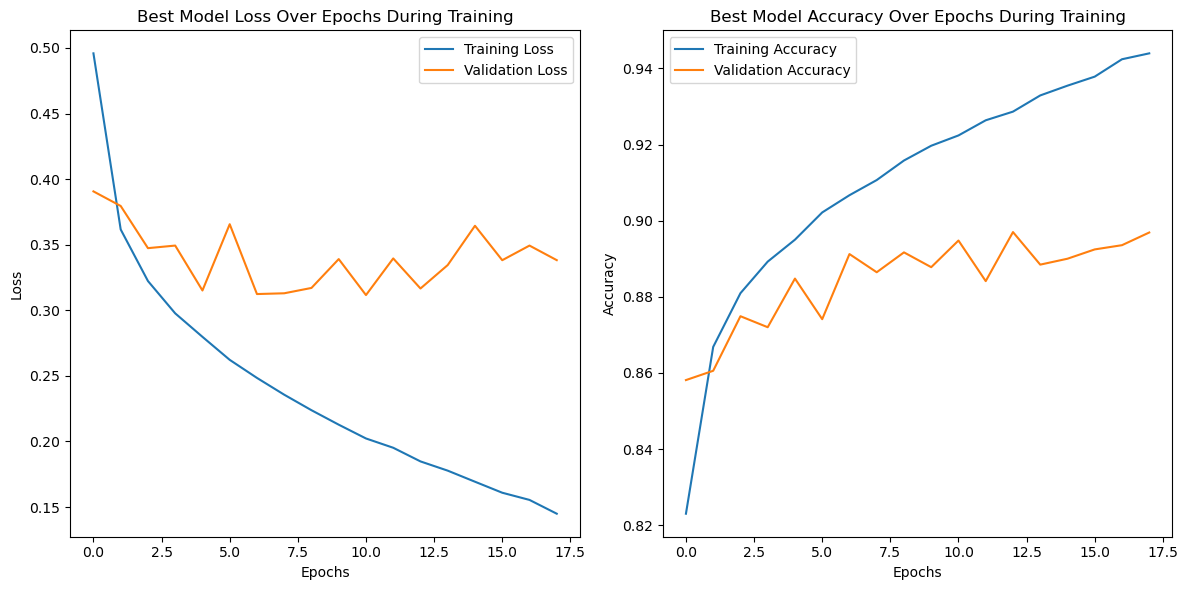

In [125]:
# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Best Model Loss Over Epochs During Training')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Best Model Accuracy Over Epochs During Training')

plt.tight_layout()
plt.show()


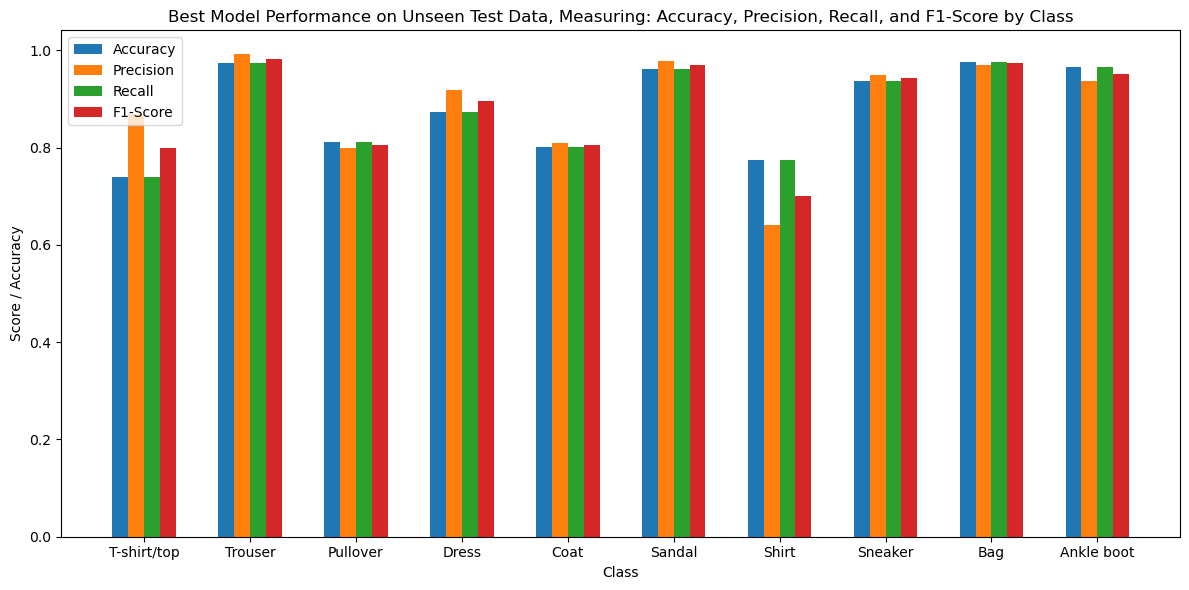

In [126]:
# Get precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=None)

# Calculate accuracy for each class
correct_per_class = np.sum((y_test == y_pred_classes) & (y_test == class_indices[:, np.newaxis]), axis=1)
total_per_class = np.bincount(y_test)
accuracy_per_class = correct_per_class / total_per_class

# Define class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create an array of class indices
class_indices = np.arange(len(class_labels))

# Create subplots for accuracy, precision, recall, and F1-score
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.15

# Plot accuracy, precision, recall, F1-score
ax.bar(class_indices - 1.5 * width, accuracy_per_class, width, label='Accuracy', align='center')
ax.bar(class_indices - 0.5 * width, precision, width, label='Precision', align='center')
ax.bar(class_indices + 0.5 * width, recall, width, label='Recall', align='center')
ax.bar(class_indices + 1.5 * width, f1, width, label='F1-Score', align='center')

# Set labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Score / Accuracy')
ax.set_title('Best Model Performance on Unseen Test Data, Measuring: Accuracy, Precision, Recall, and F1-Score by Class')
ax.set_xticks(class_indices)
ax.set_xticklabels(class_labels)
ax.legend()

plt.tight_layout()
plt.show()
